# Molecule Unfolding with Quantum Annealing

In [1]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

__NOTE__: Enter your desired device and S3 location (bucket and prefix). Remember that bucket names for Amazon Braket always begin with "amazon-braket-".

In [3]:
# Please enter the S3 bucket you created during onboarding
# (or any other S3 bucket starting with 'amazon-braket-' in your account) in the code below

my_bucket = f"amazon-braket-1a222675c751" # the name of the bucket
my_prefix = "annealer-experiment" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [4]:
# choose the D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

# or choose the D-Wave Advantage device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system1")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)
Device: Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1)


In [5]:
# investigate D-Wave device properties
device.properties.provider
device_name = device.name
qubit_count = device.properties.provider.qubitCount
number_couplers = len(device.properties.provider.couplers)
shots_range = device.properties.service.shotsRange
print('Running on {} with {} physical qubits, {} couplers and shots in the range {}.'.format(device_name,
                                                                                             qubit_count,
                                                                                             number_couplers,
                                                                                             shots_range))

Running on Advantage_system1.1 with 5760 physical qubits, 37440 couplers and shots in the range (1, 10000).


## The structures of D-Wave QPUs

D-Wave's 2000Q hardware has a Chimera graph, which has 2048 qubits, consisting of $16 \times 16$ unit cells of $8$ qubits each.
The connectivity within such a unit cell of the Chimera graph is displayed in the following figure (taken from the D-Wave documentation [here](https://docs.dwavesys.com/docs/latest/c_gs_4.html)):  

<div>
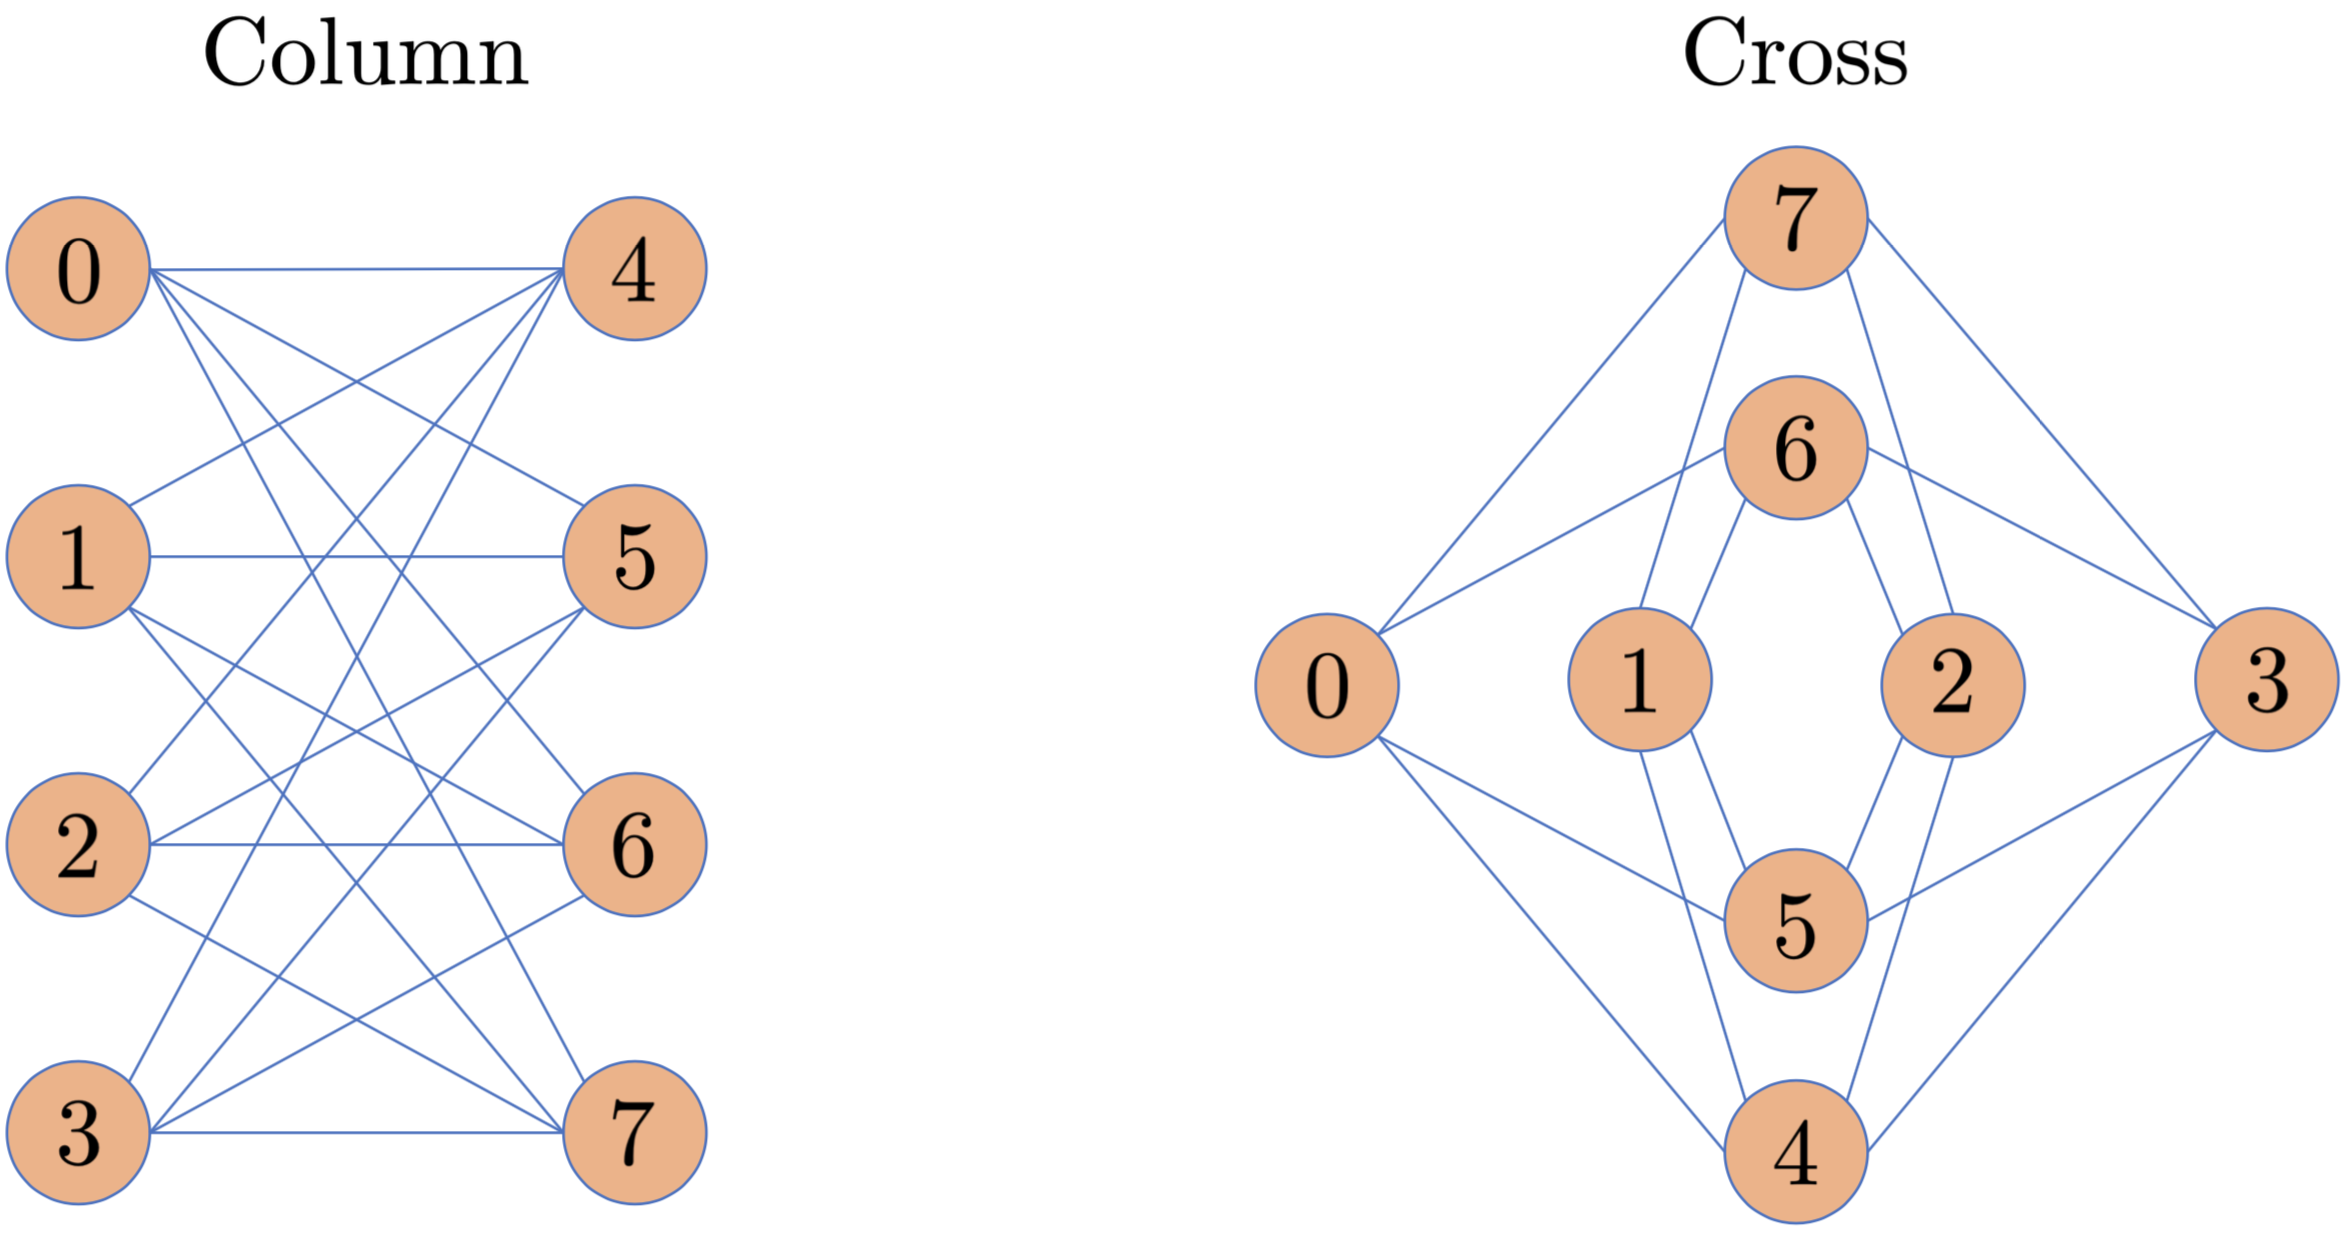
</div>

The Advantage hardware has a Pegasus graph, with in total 5760 qubits. The structure and the connectivity of the Pegasus graph can be described with the following figure (also taken [here](https://docs.dwavesys.com/docs/latest/c_gs_4.html)):


<div>
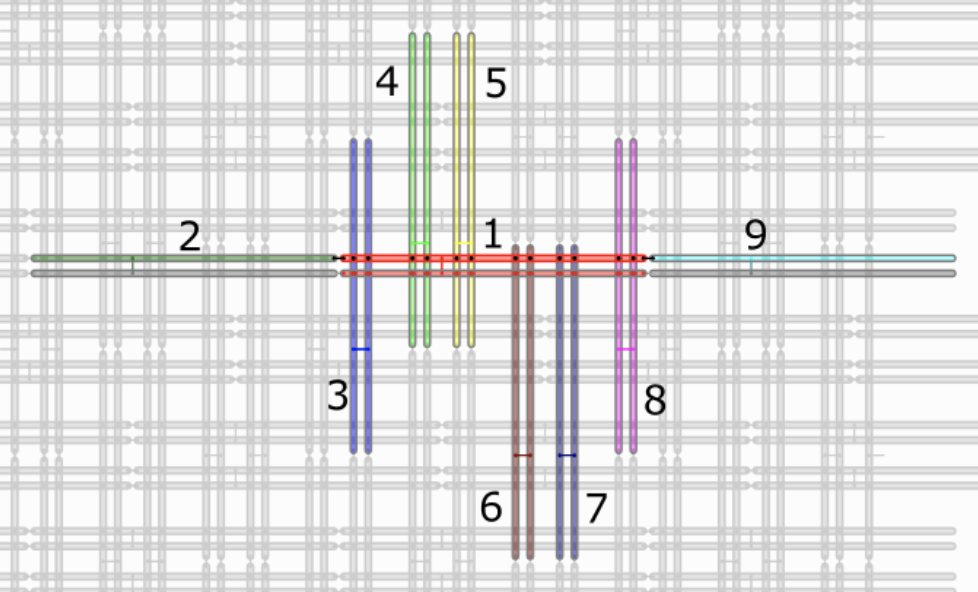
</div>

In the figure, each colored loop can be regarded as one qubit, which is associated with an odd coupler to form a pair (qubits of the same color). Take the example of qubit 1 (in red): It is internally coupled with 12 qubits (3,4,5,6,7,8) and externally coupled with 2 adjacent qubits (2,9) in the same direction.

__Working graph__: In a D-Wave QPU, the set of qubits and couplers that are available for computation is known as the *working graph*. Because of production imperfections, the yield of a working graph is typically less than the total number of qubits and couplers that are fabricated and physically present in the QPU.

Both the Chimera and the Pegasus graphs are available as a ```networkx``` graph in the package ```dwave_networkx```. 
Using this package, you can visualize some small versions of both graphs [2,3]. 

### The Chimera graph

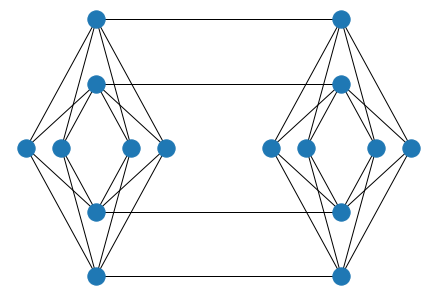

In [6]:
# show 1x2 Chimera graph
connectivity_structure = dnx.chimera_graph(1, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

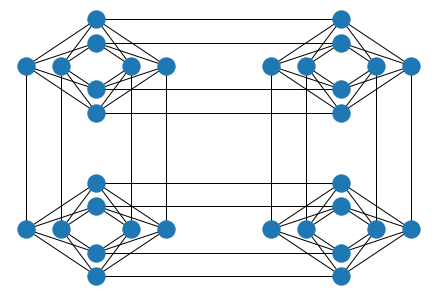

In [7]:
# show 2x2 Chimera graph
connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

### The Pegasus graph

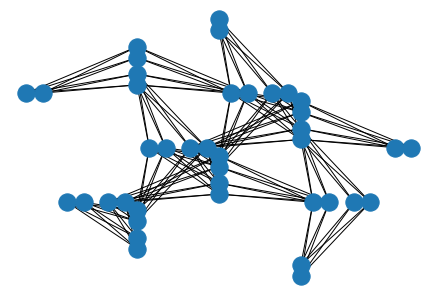

In [8]:
# show the basic Pegasus graph
connectivity_structure = dnx.pegasus_graph(2)
dnx.draw_pegasus(connectivity_structure)
plt.show()

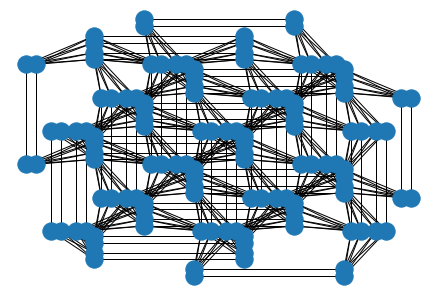

In [9]:
# show a larger Pegasus graph
connectivity_structure = dnx.pegasus_graph(3)
dnx.draw_pegasus(connectivity_structure)
plt.show()

## Finding an embedding  

The next cell generates a fully-connected graph with 9 vertices and $4\times8=32$ nodes. Such fully connected graphs cannot fit onto the sparse graph of the underlying hardware. The following example shows how to use the ```minorminer``` funtion to find an embedding on a Chimera graph.

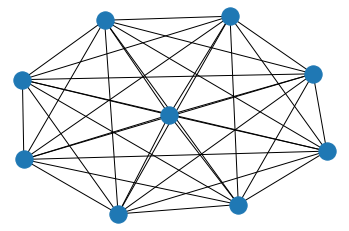

In [10]:
# generate a fully connected graph with 9 qubits
G = nx.complete_graph(9)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

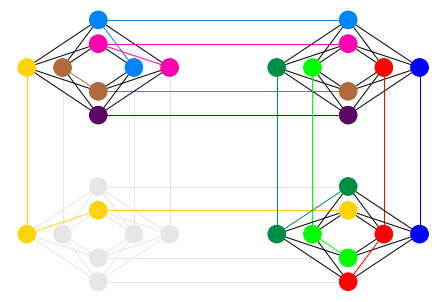

In [11]:
# find an embedding on Chimera using minorminer
connectivity_structure = dnx.chimera_graph(2, 2)
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

# plot this mebedding
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
plt.show()

Here, qubits that have the same color correspond to one logical variable in the original problem defined by the $K_{9}$ graph. Qubits combined in such way form a chain. Even though the problem only has $9$ variables (nodes), a large portion of all 32 available physical qubits are used on the toy Chimera graph.

In [12]:
# print the embedding
print(embedded_graph.items())

dict_items([(0, [11, 27]), (1, [30, 9, 25]), (2, [31, 10, 26]), (3, [3, 13, 5]), (4, [0, 16, 21, 29]), (5, [2, 12, 4]), (6, [28, 8, 24]), (7, [1, 14, 6]), (8, [15, 7])])


In [13]:
# find the maximum chain length
max_chain_length = 0
for _, chain in embedded_graph.items():
    if len(chain) > max_chain_length:
        max_chain_length = len(chain)
print('Maximum chain length in embedded graph (overhead):', max_chain_length)

Maximum chain length in embedded graph (overhead): 4


The chain on the hardware is implemented by having very strong couplings between the elements in a chain (as indicated by the bold, red connections $J_{\mathrm{chain}}$ in the first figure), chosen to be twice as strong as what the user can set. 
This enforces physical qubits to take on the same logical value. 
Still, long chains can break, leading to inconsistent results. 
In general, shorter chains (with smaller overhead) are preferable, so you do not waste physical qubits and can obtain more reliable results [2].

## Setting up and solving QUBO problems 

This section shows how to set up and solve a QUBO (or Ising) problem. This demonstration uses several sampling strategies: ```SimulatedAnnealingSampler``` and ```ExactSolver``` are used for classical benchmarking; next, the same problem is solved with the D-Wave's QPU using ```BraketDWaveSampler```. 

In general, any sampler accepts a binary quadratic model (BQM) as defined in the next cell as model input and returns variable assignments in its response. 

### Problem setup

The example considered in this section is a graph-coloring problem on a simple, small graph with five vertices (labelled $0$ to $4$), six edges and maximum degree of three, as illustrated below. 
The aim is to find a partition of all nodes into two subsets with maximum cut. 
Here, one scores a point whenever an edge connects two nodes with different colors. 
This is the NP-hard [Maximum-Cut problem](https://en.wikipedia.org/wiki/Maximum_cut). 
<div>
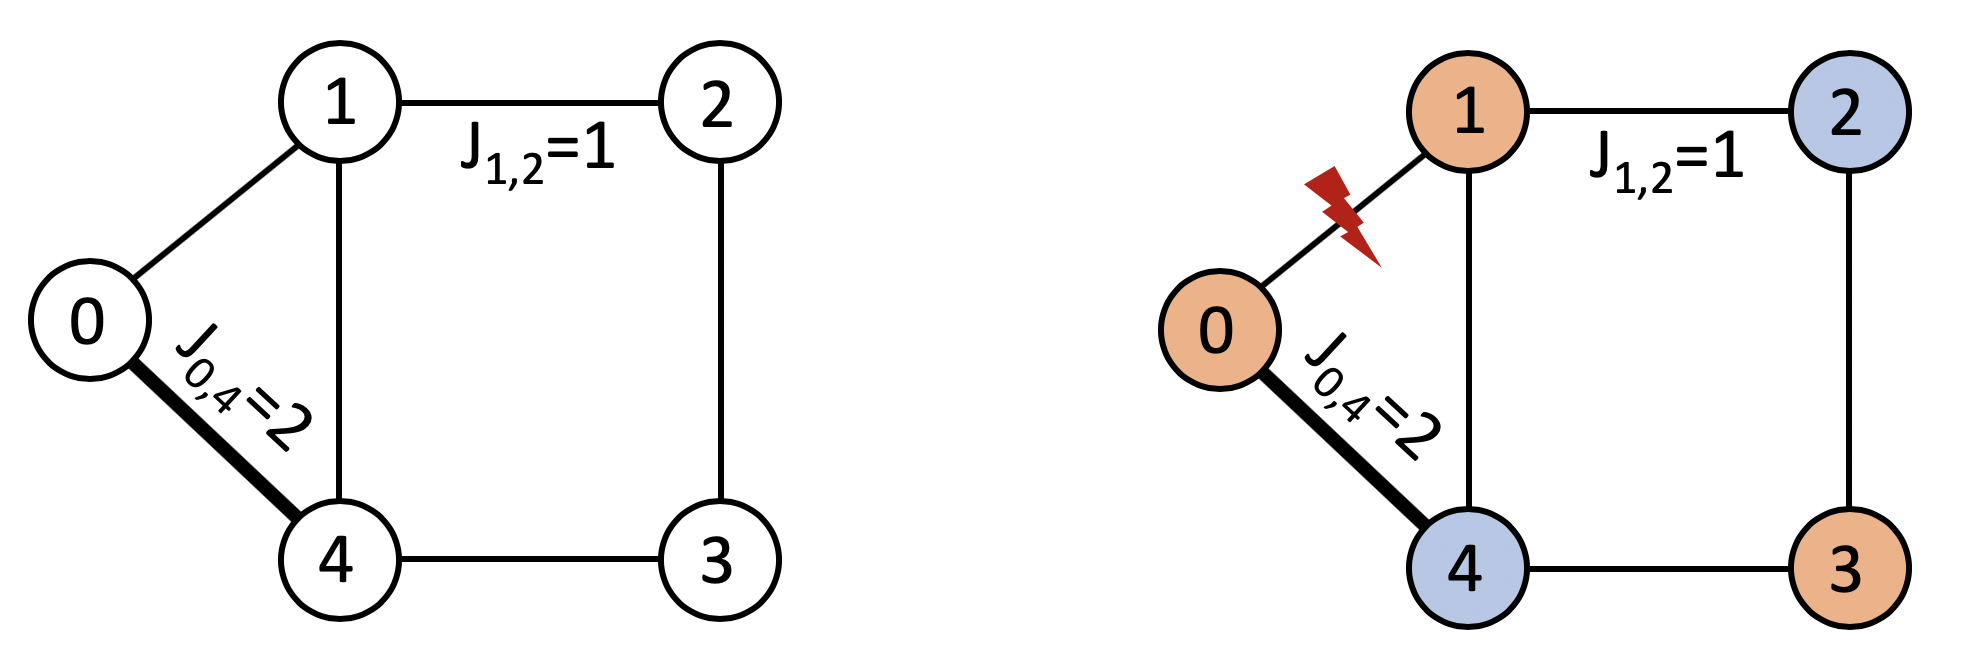
</div>

The problem is set up by defining (i) a constant offset term (which only affects the value of the energy but does not affect the variable configuration), and both (ii) linear and (iii) quadratic terms defined as dictionaries, as shown in the next cell. 

In [14]:
# define QUBO problem as BinaryQuadraticModel
quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
linear = {}
offset = 0.0

In [1]:
import numpy as np
import logging
import dimod
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

logging.getLogger().setLevel(logging.INFO)

In [2]:
# experiment for biopandas
from biopandas.pdb import PandasPdb

def residue_func(row):
    return row['residue_name'] + '_' + str(row['residue_number'])

ligand = PandasPdb().read_pdb('./peptide.pdb')
ligand_pddf = ligand.df['ATOM']
ligand_pddf['residue_name'] = ligand_pddf.apply(lambda row: residue_func(row),axis=1)
ligand_pddf.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,SER_1,,,1,,...,-0.178,-1.195,0.967,1.0,0.0,,P,,NaN,3
1,ATOM,2,,HT1,,SER_1,,,1,,...,-1.123,-1.526,0.690,1.0,0.0,,P,,NaN,4
2,ATOM,3,,HT2,,SER_1,,,1,,...,-0.162,-0.948,1.976,1.0,0.0,,P,,NaN,5
3,ATOM,4,,HT3,,SER_1,,,1,,...,0.526,-1.956,0.819,1.0,0.0,,P,,NaN,6
4,ATOM,5,,CA,,SER_1,,,1,,...,0.267,-0.021,0.130,1.0,0.0,,P,,NaN,7


In [3]:
def sub_list(l1, l2):
    result = []
    for n in range(len(l1)):
        result.append(l1[n]-l2[n])
    return result

def add_list(l1, l2):
    result = []
    for n in range(len(l1)):
        result.append(l1[n]+l2[n])
    return result

def rount_list(l):
    result = []
    for n in l:
        result.append(round(n, 4))
    return result
"""
    Return a point rotated about an arbitrary axis in 3D.
    Positive angles are counter-clockwise looking down the axis toward the origin.
    The coordinate system is assumed to be right-hand.
    Arguments: 'axis point 1', 'axis point 2', 'point to be rotated', 'angle of rotation (in radians)' >> 'new point' 
"""
def PointRotate3D(p1, p2, p0, theta):
#     from point import Point
    from math import cos, sin, sqrt

    # Translate so axis is at origin    
    p = sub_list(p0, p1)
    # Initialize point q
    q = [0.0,0.0,0.0]
    N = sub_list(p2, p1)
#     Nm = sqrt(N.x**2 + N.y**2 + N.z**2)
    Nm = sqrt(N[0]**2 + N[1]**2 + N[2]**2)
    
    # Rotation axis unit vector
    n = [N[0]/Nm, N[1]/Nm, N[2]/Nm]

    # Matrix common factors     
    c = cos(theta)
    t = (1 - cos(theta))
    s = sin(theta)
    X = n[0]
    Y = n[1]
    Z = n[2]

    # Matrix 'M'
    d11 = t*X**2 + c
    d12 = t*X*Y - s*Z
    d13 = t*X*Z + s*Y
    d21 = t*X*Y + s*Z
    d22 = t*Y**2 + c
    d23 = t*Y*Z - s*X
    d31 = t*X*Z - s*Y
    d32 = t*Y*Z + s*X
    d33 = t*Z**2 + c

    #            |p.x|
    # Matrix 'M'*|p.y|
    #            |p.z|
    q[0] = d11*p[0] + d12*p[1] + d13*p[2]
    q[1] = d21*p[0] + d22*p[1] + d23*p[2]
    q[2] = d31*p[0] + d32*p[1] + d33*p[2]

    # Translate axis and rotated point back to original location
    sum_p = add_list(q, p1)
    final_p = rount_list(sum_p)
    return final_p

In [4]:
# stats about num for each atom group
# https://stackoverflow.com/questions/46498118/pandas-use-one-column-for-groupby-and-get-stats-for-multiple-other-columns
ligand_number_pddf = ligand_pddf[['atom_number', 'residue_name']].groupby('residue_name').agg(['min', 'max'])
ligand_number_pddf.columns = ligand_number_pddf.columns.map('{0[0]}_{0[1]}'.format)
ligand_number_pddf = ligand_number_pddf.reset_index()
atom_list = ligand_number_pddf['residue_name'].values
ligand_number_pddf.head()

,residue_name,atom_number_min,atom_number_max
0,ASN_4,52,65
1,GLU_6,86,100
2,ILE_2,14,32
3,ILE_3,33,51
4,LEU_8,123,142


In [5]:
# get torsion group
atom_number_min = {}
atom_number_max = {}
torsion_group = {}

for index, row in ligand_number_pddf.iterrows():
    # update data dict
    atom_number_min[row['atom_number_min']] = row['residue_name']
    atom_number_max[row['atom_number_max']] = row['residue_name']

for k,v in atom_number_min.items():
    max_candidate = k - 1
    if max_candidate in atom_number_max.keys():
        torsion_name = [atom_number_max[max_candidate], v]
        torsion_group[max_candidate] = torsion_name

sort_torsion_group = sorted(torsion_group.items())
sort_torsion_group

[(13, ['SER_1', 'ILE_2']),
 (32, ['ILE_2', 'ILE_3']),
 (51, ['ILE_3', 'ASN_4']),
 (65, ['ASN_4', 'PHE_5']),
 (85, ['PHE_5', 'GLU_6']),
 (100, ['GLU_6', 'LYS_7']),
 (122, ['LYS_7', 'LEU_8'])]

In [6]:
# construct fragment group
fragment_group = {}

def get_pts(name, ligand):
    atom_pddf = ligand.loc[(ligand['residue_name'] == name)]
    
    max_idx = max(atom_pddf['atom_number'])
    pts_len = len(atom_pddf)
    min_idx = max_idx - pts_len + 1
    
    max_pts = []
    max_pts.append(float(atom_pddf[atom_pddf['atom_number']==max_idx]['x_coord'].values[0]))
    max_pts.append(float(atom_pddf[atom_pddf['atom_number']==max_idx]['y_coord'].values[0]))
    max_pts.append(float(atom_pddf[atom_pddf['atom_number']==max_idx]['z_coord'].values[0]))

    min_pts = []
    min_pts.append(float(atom_pddf[atom_pddf['atom_number']==min_idx]['x_coord'].values[0]))
    min_pts.append(float(atom_pddf[atom_pddf['atom_number']==min_idx]['y_coord'].values[0]))
    min_pts.append(float(atom_pddf[atom_pddf['atom_number']==min_idx]['z_coord'].values[0]))

    mid_pts = []

    for idx in range(min_idx+1, max_idx):
        current_pts = []
        current_pts.append(float(atom_pddf[atom_pddf['atom_number']==idx]['x_coord'].values[0]))
        current_pts.append(float(atom_pddf[atom_pddf['atom_number']==idx]['y_coord'].values[0]))
        current_pts.append(float(atom_pddf[atom_pddf['atom_number']==idx]['z_coord'].values[0]))
        mid_pts.append(current_pts)
        
    return min_idx, max_idx, range(min_idx+1, max_idx), min_pts, max_pts, mid_pts

for tor in sort_torsion_group:
    first_red_idx = tor[0]
    first_red_name = tor[1][0]
    second_red_name = tor[1][1]
    if first_red_name not in fragment_group.keys():
        min_idx, max_idx, mid_idx, min_pts, max_pts, mid_pts = get_pts(first_red_name, ligand_pddf)
        initial_value = {}
        initial_value['min_pts'] = [min_pts]
        initial_value['mid_pts'] = mid_pts
        initial_value['max_pts'] = [max_pts]
        initial_value['min_idx'] = [min_idx]
        initial_value['mid_idx'] = mid_idx
        initial_value['max_idx'] = [max_idx]
        fragment_group[first_red_name] = initial_value
        
    if second_red_name not in fragment_group.keys():
        min_idx, max_idx, mid_idx, min_pts, max_pts, mid_pts = get_pts(second_red_name, ligand_pddf)
        initial_value = {}
        initial_value['min_pts'] = [min_pts]
        initial_value['mid_pts'] = mid_pts
        initial_value['max_pts'] = [max_pts]
        initial_value['min_idx'] = [min_idx]
        initial_value['mid_idx'] = mid_idx
        initial_value['max_idx'] = [max_idx]
        fragment_group[second_red_name] = initial_value

In [7]:
def get_idx(var):
    return int(var.split('_')[1])-1

def get_theta(var, theta_option):
    return theta_option[int(var.split('_')[-1])-1]

def get_current_pts(fragment_name, fragment_group, pts_name, pts_dict):
    target_pts = []
    if fragment_name not in pts_dict.keys():
        target_pts = fragment_group[fragment_name][pts_name]
    else:
        if pts_name not in pts_dict[fragment_name].keys():
            target_pts = fragment_group[fragment_name][pts_name]    
        else:
            target_pts = pts_dict[fragment_name][pts_name]
    return target_pts

def update_pts(start_pts, end_pts, pts_list, rotate_theta):
    rotate_list = []
    logging.debug("start_pts {}".format(start_pts))
    logging.debug("end_pts {}".format(end_pts))
    logging.debug("pts_list {}".format(pts_list))
    pi = 3.1415926
    for pt in pts_list:
        rotate_list.append(PointRotate3D(start_pts[0], end_pts[0], pt, rotate_theta/180*pi))
    return rotate_list

def update_pts_dict(target_name, pts_name, pts_dict, rotate_pts):
    if target_name not in pts_dict.keys():
        pts_dict[target_name] = {}
    pts_dict[target_name][pts_name] = rotate_pts
    
def calc_distance_between_pts(pts1, pts2):
    pts1_middle = np.array(tuple(list(np.mean(np.array(pts1), axis=0))))
    pts2_middle = np.array(tuple(list(np.mean(np.array(pts2), axis=0))))
    return np.linalg.norm(pts1_middle-pts2_middle)

def calc_distance_func(rotate_values, sort_torsion_group, fragment_group, theta_option):
    # save temp results for pts
    temp_pts_dict = {}
    
    tor_base_idx = get_idx(rotate_values[0])
    tor_len = len(rotate_values)
    tor_target_idx = get_idx(rotate_values[tor_len-1])
    
    current_start_idx = []
    
    for left_idx in range(tor_len):
        # get rotate theta
        tor_start_value = rotate_values[left_idx]
        tor_start_idx = get_idx(tor_start_value)
        tor_start = sort_torsion_group[tor_start_idx]
        rotate_theta = get_theta(tor_start_value, theta_option)
        # rotate points
        start_name = tor_start[1][0]
        start_pts = get_current_pts(start_name, fragment_group, 'max_pts', temp_pts_dict)

        end_name = tor_start[1][1]
        end_pts = get_current_pts(end_name, fragment_group, 'min_pts', temp_pts_dict)
        logging.debug("current tor {} with base_idx {} rotate_theta {}".format(tor_start_value, tor_start_idx, rotate_theta))
        
        for right_idx in range(left_idx,tor_len):
            tor_end_value = rotate_values[right_idx]
            tor_end_idx = get_idx(tor_end_value)
            tor_end = sort_torsion_group[tor_end_idx]
            logging.debug("update tor  {}, tor_end_id is {}, tor_target_idx is {}".format(tor_end, tor_end_idx, tor_end_idx))
#             only update min/max pts

            # rotate target min/max pts
            end_name = tor_end[1][1]

            end_min_pts = get_current_pts(end_name, fragment_group, 'min_pts', temp_pts_dict)
            end_max_pts = get_current_pts(end_name, fragment_group, 'max_pts', temp_pts_dict)

            end_min_rotate_pts = update_pts(start_pts, end_pts, end_min_pts, rotate_theta)
            end_max_rotate_pts = update_pts(start_pts, end_pts, end_max_pts, rotate_theta)

            update_pts_dict(end_name, 'min_pts', temp_pts_dict, end_min_rotate_pts)
            update_pts_dict(end_name, 'max_pts', temp_pts_dict, end_max_rotate_pts)
            
            
            if int(tor_end_idx) == int(tor_target_idx):
                # update all the pts
                logging.debug("update all pts!!!!!!!!")
                mid_pts = get_current_pts(end_name, fragment_group, 'mid_pts', temp_pts_dict)
                end_mid_rotate_pts = update_pts(start_pts, end_pts, mid_pts, rotate_theta)
                
#                 fragment_group[target_pts_name]['mid_pts'] = target_mid_rotate_pts
                update_pts_dict(end_name, 'mid_pts', temp_pts_dict, end_mid_rotate_pts)
            
            logging.debug("#########pts_dict {}".format(temp_pts_dict))
            
    base_name = sort_torsion_group[tor_base_idx][1][0]
    target_name = sort_torsion_group[tor_target_idx][1][1]
    base_pts = fragment_group[base_name]['mid_pts'] + fragment_group[base_name]['min_pts'] + fragment_group[base_name]['max_pts']
    target_pts = temp_pts_dict[target_name]['mid_pts'] + temp_pts_dict[target_name]['min_pts'] + temp_pts_dict[target_name]['max_pts']
    logging.debug("base pts {}".format(base_pts))
    logging.debug("target pts {} ".format(target_pts))
    distance = calc_distance_between_pts(base_pts, target_pts)
    
    return distance

In [8]:
# Torsion（m）；Options for score（d）
# Variables （v = m * d）
# initial variable string
# M = len(sort_torsion_group)
M = 4
# 0, 90, 180, 270
D = 4
theta_option = [x * 360/D for x in range(D)]
var = {}

for m in range(M):
    x_d = {}
    for d in range(D):
        x_d[d+1] = 'x_{}_{}'.format(m+1, d+1)
    var[m+1] = x_d 

In [9]:
# initial constraint 
A = 10000
hubo = {}
for m in range(M):
    for d1 in range(D):
        var_1 = var[m+1][d1+1]
        for d2 in range(D):
            var_2 = var[m+1][d2+1]
            if (var_2, var_1) in hubo.keys():
                hubo[(var_2,var_1)] = hubo[(var_2, var_1)] + A
            elif var_1 == var_2:
                hubo[(var_1,)] = -A
            else:
                hubo[(var_1, var_2)] = A
                
#         hubo[(var_1,)] = -A

In [10]:
# initial distance function: D_a_b
hubo_distances = {}
# fragment num
F = M+1

def update_hubo(tor_group, up_list):
    if len(tor_group) == 1:
#         print(tor_group)
        for d in range(D):
            final_list = up_list + [var[tor_group[0]][d+1]]
            # distance
            hubo_distances[tuple(final_list)] = -calc_distance_func(tuple(final_list), sort_torsion_group, fragment_group, theta_option)
    else:
        for d in range(D):
            final_list = up_list + [var[tor_group[0]][d+1]]
            update_hubo(tor_group[1:], final_list)

for a in range(F):
    for b in range(a+1,F):
        logging.info("fragment {}-{}".format(a,b))
        start_pos = a
        end_pos = b-a
        torsion_group = []
        while(end_pos > 0):
            torsion_pos = start_pos + 1
#             print("torsion {}".format(torsion_pos))
            start_pos = start_pos + 1
            end_pos = end_pos - 1
            torsion_group.append(torsion_pos)
        logging.info("torsion group {}".format(torsion_group))
        # update hubo
        update_hubo(torsion_group, [])

INFO:root:fragment 0-1
INFO:root:torsion group [1]
INFO:root:fragment 0-2
INFO:root:torsion group [1, 2]
INFO:root:fragment 0-3
INFO:root:torsion group [1, 2, 3]
INFO:root:fragment 0-4
INFO:root:torsion group [1, 2, 3, 4]
INFO:root:fragment 1-2
INFO:root:torsion group [2]
INFO:root:fragment 1-3
INFO:root:torsion group [2, 3]
INFO:root:fragment 1-4
INFO:root:torsion group [2, 3, 4]
INFO:root:fragment 2-3
INFO:root:torsion group [3]
INFO:root:fragment 2-4
INFO:root:torsion group [3, 4]
INFO:root:fragment 3-4
INFO:root:torsion group [4]


In [11]:
hubo.update(hubo_distances)

In [12]:
qubo = dimod.make_quadratic(hubo, 5, dimod.BINARY)

### Classical benchmark: simulated annealing

First, run this problem using (classical) simulated annealing, as offered as part of D-Wave's ```dimod``` module. ```SimulatedAnnealingSampler``` is a [reference implementation](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampler_composites/samplers.html#module-dimod.reference.samplers.simulated_annealing) of a simulated annealing sampler, with ```neal.sampler.SimulatedAnnealingSampler``` being a more performant implementation of simulated annealing you may try to use for solving problems. 
The following formulates this problem in Ising form with variables that take on the values $\pm 1$.

In [13]:
# set parameters
num_shots = 10
# vartype = dimod.SPIN

# # run classical simulated annealing
# model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(qubo, num_reads=num_shots)

# print results
print(response)

  x_1_1 x_1_1*x_4_1 x_1_1*x_4_2 ... x_4_4*x_1_4       energy num_oc.
7     1           1           1 ...           1  -2110.16765       1
2     0           1           1 ...           1 -2101.192355       1
4     1           1           1 ...           1 -2083.101583       1
5     0           1           1 ...           1 -2074.773517       1
1     0           1           1 ...           1 -2066.774162       1
9     0           1           1 ...           1 -2058.503672       1
8     1           1           1 ...           1 -2050.338662       1
6     0           1           1 ...           1 -2044.275455       1
0     0           1           1 ...           1 -2015.739078       1
3     0           1           1 ...           1 -2005.574729       1
['BINARY', 10 rows, 10 samples, 48 variables]


The ```response``` object lists all sampling results as individual rows, with energy and number of occurrences for each case. 
You can access this information in more compact form using the ```aggregate()``` method as shown in the next cell and described [here](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/generated/dimod.SampleSet.aggregate.html). 

In [14]:
# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

  x_1_1 x_1_1*x_4_1 x_1_1*x_4_2 ... x_4_4*x_1_4       energy num_oc.
7     1           1           1 ...           1  -2110.16765       1
2     0           1           1 ...           1 -2101.192355       1
4     1           1           1 ...           1 -2083.101583       1
5     0           1           1 ...           1 -2074.773517       1
1     0           1           1 ...           1 -2066.774162       1
9     0           1           1 ...           1 -2058.503672       1
8     1           1           1 ...           1 -2050.338662       1
6     0           1           1 ...           1 -2044.275455       1
0     0           1           1 ...           1 -2015.739078       1
3     0           1           1 ...           1 -2005.574729       1
['BINARY', 10 rows, 10 samples, 48 variables]


The two degenerate optimal solutions with energy $-5.0$ are connected by a so-called $\mathbb{Z}_{2}$ symmetry. 
This means that the choice of coloring is arbitrary, since it does not make a difference if coloring one set of nodes $\{0,1,3\}$ red and the remaining ones $\{2,4\}$ blue or the other way around. 
However, if you add one linear term, this symmetry is broken and a unique solution is preferred as shown in the next cell. 

### Quantum annealing on D-Wave QPUs

In [15]:
# Please enter the S3 bucket you created during onboarding
# (or any other S3 bucket starting with 'amazon-braket-' in your account) in the code below

my_bucket = f"amazon-braket-1a222675c751" # the name of the bucket
my_prefix = "annealer-experiment" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [18]:
# set parameters
num_reads = 1000

# run BQM: solve with the D-Wave 2000Q device
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
sampleset = sampler.sample(qubo, num_reads=num_reads)

# print solution
print(sampleset)

    x_1_1 x_1_1*x_4_1 x_1_1*x_4_2 ... x_4_4*x_1_4       energy num_oc. ...
559     0           1           1 ...           1 -1308.821584       1 ...
855     0           0           1 ...           1 -1154.063748       1 ...
863     0           1           1 ...           0 -1129.084927       1 ...
563     0           1           1 ...           1 -1051.434825       1 ...
808     0           0           1 ...           0 -1049.250015       1 ...
321     1           0           1 ...           0 -1031.204729       1 ...
966     0           1           1 ...           1 -1027.087361       1 ...
17      0           1           1 ...           1 -1009.988456       1 ...
567     0           0           1 ...           1 -1000.642627       1 ...
322     0           1           1 ...           1  -997.710723       1 ...
865     0           0           1 ...           0  -968.758389       1 ...
18      0           1           1 ...           1  -962.690801       1 ...
19      0           0    

In [19]:
# aggregate solution: 
sampleset = sampleset.aggregate()

# print solution
print(sampleset)

    x_1_1 x_1_1*x_4_1 x_1_1*x_4_2 ... x_4_4*x_1_4       energy num_oc. ...
559     0           1           1 ...           1 -1308.821584       1 ...
855     0           0           1 ...           1 -1154.063748       1 ...
863     0           1           1 ...           0 -1129.084927       1 ...
563     0           1           1 ...           1 -1051.434825       1 ...
808     0           0           1 ...           0 -1049.250015       1 ...
321     1           0           1 ...           0 -1031.204729       1 ...
966     0           1           1 ...           1 -1027.087361       1 ...
17      0           1           1 ...           1 -1009.988456       1 ...
567     0           0           1 ...           1 -1000.642627       1 ...
322     0           1           1 ...           1  -997.710723       1 ...
865     0           0           1 ...           0  -968.758389       1 ...
18      0           1           1 ...           1  -962.690801       1 ...
19      0           0    

In [22]:
# print timing info for the previous D-Wave job
sampleset.info['additionalMetadata']['dwaveMetadata']['timing']

{'qpuSamplingTime': 238940,
 'qpuAnnealTimePerSample': 20,
 'qpuAccessTime': 249669,
 'qpuAccessOverheadTime': 1589,
 'qpuReadoutTimePerSample': 198,
 'qpuProgrammingTime': 10729,
 'qpuDelayTimePerSample': 21,
 'postProcessingOverheadTime': 389,
 'totalPostProcessingTime': 389,
 'totalRealTime': None,
 'runTimeChip': None,
 'annealTimePerRun': None,
 'readoutTimePerRun': None}

This experiment focuses on the total QPU access time ```QpuAccessTime``` which can be broken up into two contributions: 
(1) a one-time initialization step to program the QPU (given by ```QpuProgrammingTime```), and 
(2) the total sampling time ```QpuSamplingTime``` that is made of repeated sampling runs involving per-sample timescales such as ```QpuAnnealTimePerSample``` and ```QpuReadoutTimePerSample```.
For more details, refer to [this page](https://docs.dwavesys.com/docs/latest/c_timing_2.html#breakdown-of-qpu-access-time) in the Ocean documentation.  

The following analyzes how these timescales depend on the number of logical variables for a canonical NP-hard QUBO problem, namely a specific graph partitioning problem as described in great detail [here](https://github.com/dwave-examples/graph-partitioning).
In short, here the goal is to partition all nodes into two subsets of equal size while minimizing the number of cut edges between these two subsets. 
In other words, one needs to color the graph such to have the same number of blue and red nodes with the number of edges connecting blue and red nodes being as small as possible. 

### Helper functions

First, set up some helper functions. 
The function ```get_graph``` plots a given graph using the ```networkx``` library. 
The function ```get_model``` generates the QUBO $Q$-matrix for graph partitioning problem based on a random graph with a given number of nodes and edge probability. 
The function ```run_qubo``` runs the QUBO problem for given graph $G$, associated QUBO-Matrix $Q$ and number of shots, outputting several timescales discussed before. 

In [23]:
# helper function to plot a graph
def get_graph(graph, pos):
    """
    plot given graph with fixed positioning
    """
    
    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=400)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [24]:
# helper function to generate the model
def get_model(nodes, prob=0.2, gamma=80):
    """
    function to generate Q matrix for graph partitioning problem 
    """
    
    # ------- Set up the graph -------
    vertices = nodes
    G = nx.gnp_random_graph(vertices, prob)

    print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
                                                                               len(G.edges), 
                                                                               len(G.nodes) * (len(G.nodes)-1) / 2))

    # ------- Plot the graph -------
    pos = nx.spring_layout(G)
    # plot graph with labels
    get_graph(G, pos)

    # ------- Set up QUBO dictionary -------

    # initialize a Q matrix
    Q = defaultdict(int)

    # fill in the Q matrix
    for u, v in G.edges:
        Q[(u,u)] += 1
        Q[(v,v)] += 1
        Q[(u,v)] += -2

    for i in G.nodes:
        Q[(i,i)] += gamma*(1-len(G.nodes))

    for i, j in combinations(G.nodes, 2):
        Q[(i,j)] += 2*gamma
    
    return G, Q

In [25]:
# helper function to run the QUBO problem
def run_qubo(G, Q, gamma=80, num_reads=1000, annealing_time=20):
    """
    run QUBO problem for given graph G, Qubo-Matrix Q and number of shots
    """
    # ------- Run the QUBO problme on the QPU -------

    # set chain strength
    nodes = len(G.nodes)
    chain_strength = gamma*nodes

    # run QUBO on Braket and keep track of runtime
    start = time.time()
    response = sampler.sample_qubo(Q, chain_strength=chain_strength, 
                                   num_reads=num_reads,
                                   annealing_time=annealing_time)
    end = time.time()
    
    # print and store runtime (wallclock time)
    runtime = end - start
    print('Runtime is {} for {} nodes.'.format(runtime, nodes))
    
    # D-Wave timescales
    QpuSamplingTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuSamplingTime']
    QpuAccessTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']
    QpuProgrammingTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuProgrammingTime']
    QpuAnnealTimePerSample = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAnnealTimePerSample']
    # TotalRealTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['totalRealTime']
    # RunTimeChip = response.info['additionalMetadata']['dwaveMetadata']['timing']['runTimeChip']
    print('QpuProgrammingTime is {} for {} nodes.'.format(QpuProgrammingTime, nodes))
    print('QpuSamplingTime is {} for {} nodes.'.format(QpuSamplingTime, nodes))
    print('QpuAccessTime is {} for {} nodes.'.format(QpuAccessTime, nodes))
    print('QpuAnnealTimePerSample is {} for {} nodes.'.format(QpuAnnealTimePerSample, nodes))
    
    # see if the best solution found is feasible, and if so print the number of cut edges.
    sample = response.record.sample[0]

    # postprocessing: analyze result
    # in the case when n is odd, the set may have one more or one fewer nodes
    if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
        num_cut_edges = 0
        for u, v in G.edges:
            num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
        print("Valid partition found with", num_cut_edges, "cut edges.")
    else:
        print("Invalid partition.")
    
    # plot result
    colors = sample
    colorlist = ['#377eb8','#e41a1c']
    nx.draw_networkx(graph, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    plt.axis('off');
    plt.show();
    
    # results as dic
    results = {'runtime': runtime, 
               'QpuSamplingTime': QpuSamplingTime,
               'QpuAccessTime': QpuAccessTime, 
               'QpuProgrammingTime': QpuProgrammingTime,
               'QpuAnnealTimePerSample': QpuAnnealTimePerSample
              }
    
    return results

### Experimental runs

Graph on 10 nodes created with 10 out of 45.0 possible edges.


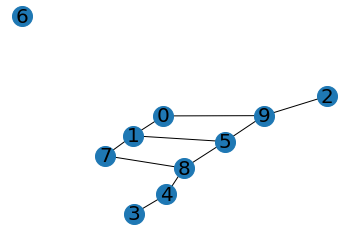

Runtime is 3.1865923404693604 for 10 nodes.
QpuProgrammingTime is 10768 for 10 nodes.
QpuSamplingTime is 2289 for 10 nodes.
QpuAccessTime is 13057 for 10 nodes.
QpuAnnealTimePerSample is 10 for 10 nodes.
Valid partition found with 3 cut edges.


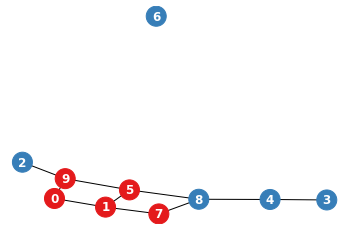

Graph on 20 nodes created with 31 out of 190.0 possible edges.


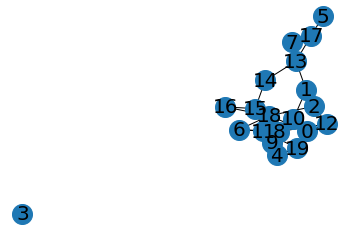

Runtime is 6.303781747817993 for 20 nodes.
QpuProgrammingTime is 10925 for 20 nodes.
QpuSamplingTime is 2289 for 20 nodes.
QpuAccessTime is 13214 for 20 nodes.
QpuAnnealTimePerSample is 10 for 20 nodes.
Valid partition found with 19 cut edges.


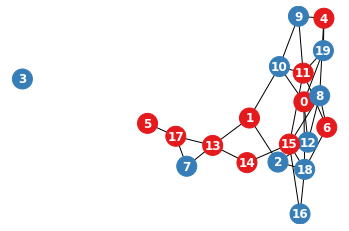

Graph on 30 nodes created with 94 out of 435.0 possible edges.


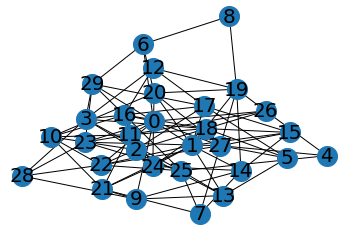

Runtime is 6.0237579345703125 for 30 nodes.
QpuProgrammingTime is 10957 for 30 nodes.
QpuSamplingTime is 2331 for 30 nodes.
QpuAccessTime is 13288 for 30 nodes.
QpuAnnealTimePerSample is 10 for 30 nodes.
Valid partition found with 52 cut edges.


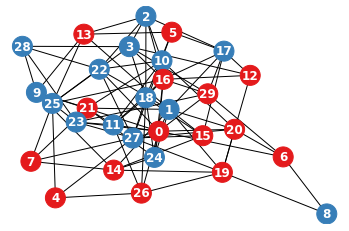

Graph on 40 nodes created with 158 out of 780.0 possible edges.


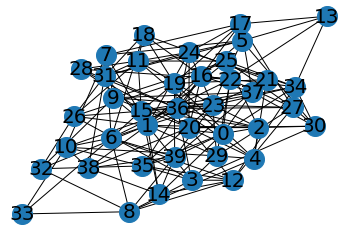

Runtime is 18.802211046218872 for 40 nodes.
QpuProgrammingTime is 10962 for 40 nodes.
QpuSamplingTime is 2344 for 40 nodes.
QpuAccessTime is 13307 for 40 nodes.
QpuAnnealTimePerSample is 10 for 40 nodes.
Invalid partition.


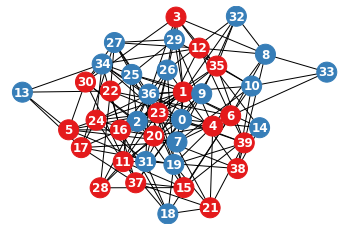

Graph on 50 nodes created with 250 out of 1225.0 possible edges.


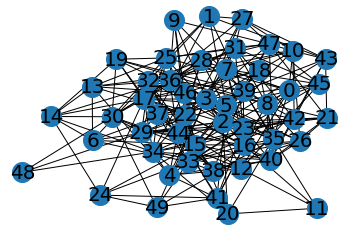

Runtime is 12.142512083053589 for 50 nodes.
QpuProgrammingTime is 10988 for 50 nodes.
QpuSamplingTime is 2344 for 50 nodes.
QpuAccessTime is 13333 for 50 nodes.
QpuAnnealTimePerSample is 10 for 50 nodes.
Valid partition found with 114 cut edges.


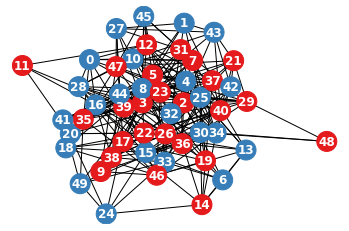

Graph on 60 nodes created with 324 out of 1770.0 possible edges.


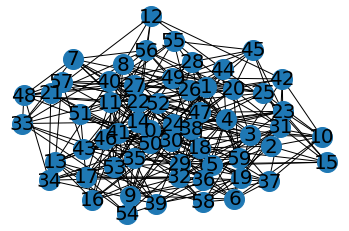

Runtime is 11.45849323272705 for 60 nodes.
QpuProgrammingTime is 11093 for 60 nodes.
QpuSamplingTime is 2344 for 60 nodes.
QpuAccessTime is 13438 for 60 nodes.
QpuAnnealTimePerSample is 10 for 60 nodes.
Invalid partition.


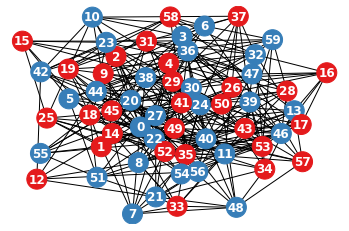

In [26]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 10 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes = [] # stores individual runtimes
QpuSamplingTimes = [] 
QpuAccessTimes = [] 
QpuProgrammingTimes = [] 
QpuAnnealTimePerSamples = []

# run for different problem sizes 
for nn in nodes:
    # define the problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes.append(runtime)
    QpuSamplingTimes.append(QpuSamplingTime)
    QpuAccessTimes.append(QpuAccessTime)
    QpuProgrammingTimes.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples.append(QpuAnnealTimePerSample)

A second set of experiments is conducted with the same parameters in order to verify the trends. 

Graph on 10 nodes created with 7 out of 45.0 possible edges.


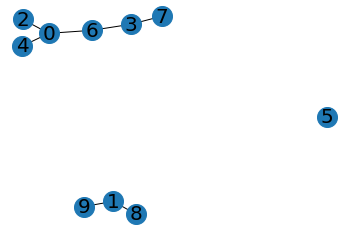

Runtime is 3.6358940601348877 for 10 nodes.
QpuProgrammingTime is 10809 for 10 nodes.
QpuSamplingTime is 2289 for 10 nodes.
QpuAccessTime is 13098 for 10 nodes.
QpuAnnealTimePerSample is 10 for 10 nodes.
Valid partition found with 2 cut edges.


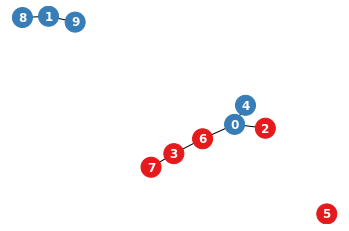

Graph on 20 nodes created with 48 out of 190.0 possible edges.


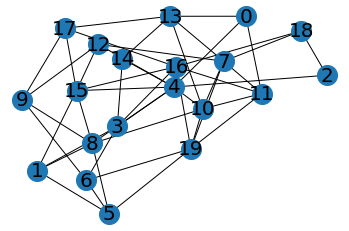

Runtime is 7.030894756317139 for 20 nodes.
QpuProgrammingTime is 10861 for 20 nodes.
QpuSamplingTime is 2344 for 20 nodes.
QpuAccessTime is 13205 for 20 nodes.
QpuAnnealTimePerSample is 10 for 20 nodes.
Valid partition found with 22 cut edges.


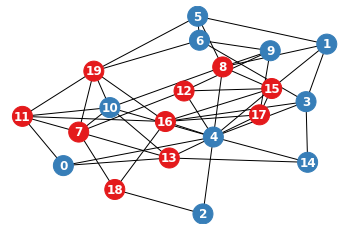

Graph on 30 nodes created with 88 out of 435.0 possible edges.


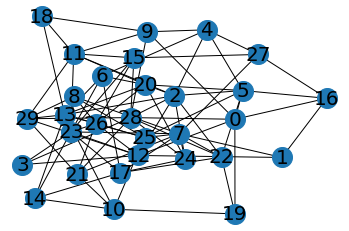

Runtime is 16.51255178451538 for 30 nodes.
QpuProgrammingTime is 10954 for 30 nodes.
QpuSamplingTime is 2344 for 30 nodes.
QpuAccessTime is 13298 for 30 nodes.
QpuAnnealTimePerSample is 10 for 30 nodes.
Valid partition found with 45 cut edges.


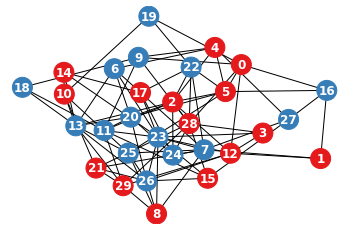

Graph on 40 nodes created with 168 out of 780.0 possible edges.


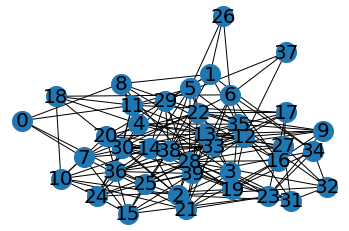

Runtime is 26.11293363571167 for 40 nodes.
QpuProgrammingTime is 10991 for 40 nodes.
QpuSamplingTime is 2344 for 40 nodes.
QpuAccessTime is 13335 for 40 nodes.
QpuAnnealTimePerSample is 10 for 40 nodes.
Invalid partition.


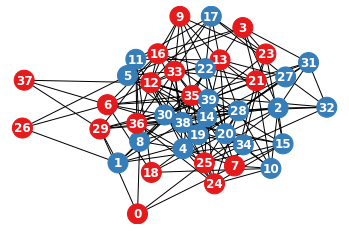

Graph on 50 nodes created with 276 out of 1225.0 possible edges.


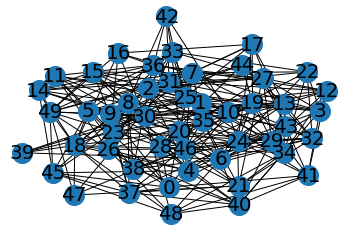

Runtime is 16.404491662979126 for 50 nodes.
QpuProgrammingTime is 11048 for 50 nodes.
QpuSamplingTime is 2344 for 50 nodes.
QpuAccessTime is 13392 for 50 nodes.
QpuAnnealTimePerSample is 10 for 50 nodes.
Invalid partition.


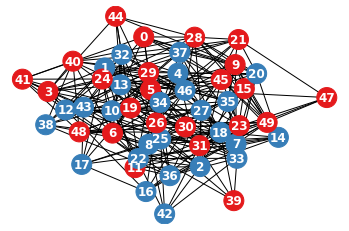

Graph on 60 nodes created with 359 out of 1770.0 possible edges.


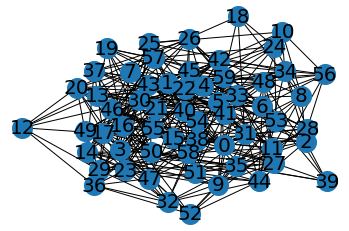

Runtime is 19.695910453796387 for 60 nodes.
QpuProgrammingTime is 11079 for 60 nodes.
QpuSamplingTime is 2344 for 60 nodes.
QpuAccessTime is 13424 for 60 nodes.
QpuAnnealTimePerSample is 10 for 60 nodes.
Valid partition found with 180 cut edges.


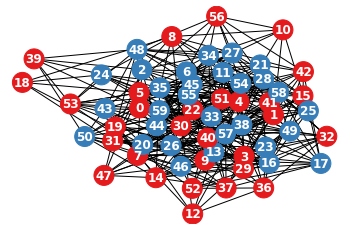

In [27]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 10 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes2 = [] # stores individual runtimes
QpuSamplingTimes2 = [] 
QpuAccessTimes2 = [] 
QpuProgrammingTimes2 = [] 
QpuAnnealTimePerSamples2 = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes2.append(runtime)
    QpuSamplingTimes2.append(QpuSamplingTime)
    QpuAccessTimes2.append(QpuAccessTime)
    QpuProgrammingTimes2.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples2.append(QpuAnnealTimePerSample)

### Results visualization

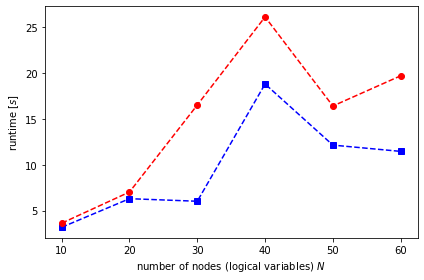

In [28]:
# plot wallclock results
plt.plot(nodes, runtimes, 'b--s')
plt.plot(nodes, runtimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('runtime $[s]$')
plt.tight_layout();
plt.savefig('dwave_wallclock_partitioning_shots_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

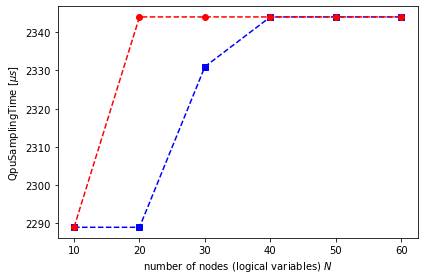

In [29]:
# plot QpuSamplingTimes results
plt.plot(nodes, QpuSamplingTimes, 'b--s')
plt.plot(nodes, QpuSamplingTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuSamplingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuSamplingTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

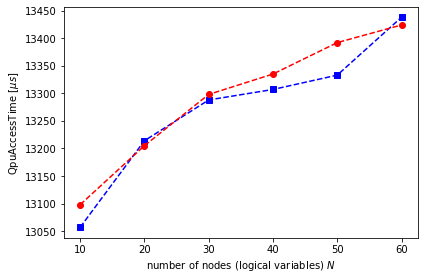

In [30]:
# plot QpuAccessTimes results
plt.plot(nodes, QpuAccessTimes, 'b--s')
plt.plot(nodes, QpuAccessTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAccessTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAccessTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

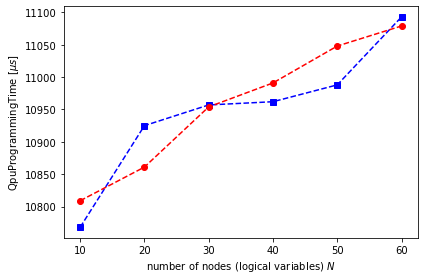

In [31]:
# plot QpuProgrammingTimes results
plt.plot(nodes, QpuProgrammingTimes, 'b--s')
plt.plot(nodes, QpuProgrammingTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuProgrammingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuProgrammingTime_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

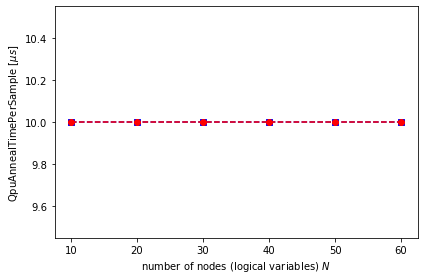

In [32]:
# plot QpuAnnealTimePerSamples results
plt.plot(nodes, QpuAnnealTimePerSamples, 'b--s')
plt.plot(nodes, QpuAnnealTimePerSamples2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAnnealTimePerSample $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAnnealTimePerSample_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

With those results, the following observations can be made: 
The wallclock time a user experiences tends to increase with the number of variables, potentially showing spikes that can come from somewhat random queuing times. 
All other timescales are independent of queuing. 
The total QPU access time increases with the number of variables, following the trend given by the QPU programming time, while the QPU sampling time is a flat contribution to the QPU access time. 
The QPU annealing time per sample is constant, taking on the value set with the ```annealing_time``` parameter.
To investigate the dependence of all timescales on this parameter, the following runs another set of experiments with a different value for this parameter. 

Graph on 10 nodes created with 10 out of 45.0 possible edges.


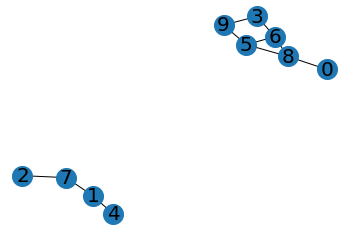

Runtime is 3.2814781665802 for 10 nodes.
QpuProgrammingTime is 10818 for 10 nodes.
QpuSamplingTime is 3189 for 10 nodes.
QpuAccessTime is 14007 for 10 nodes.
QpuAnnealTimePerSample is 100 for 10 nodes.
Valid partition found with 6 cut edges.


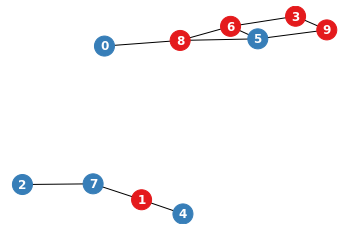

Graph on 20 nodes created with 34 out of 190.0 possible edges.


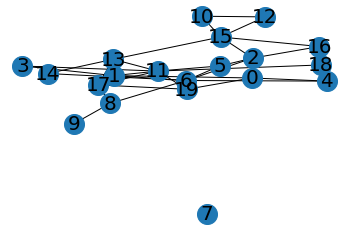

Runtime is 5.362935781478882 for 20 nodes.
QpuProgrammingTime is 10875 for 20 nodes.
QpuSamplingTime is 3189 for 20 nodes.
QpuAccessTime is 14065 for 20 nodes.
QpuAnnealTimePerSample is 100 for 20 nodes.
Valid partition found with 15 cut edges.


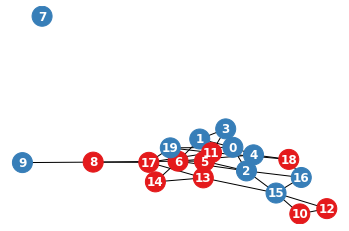

Graph on 30 nodes created with 73 out of 435.0 possible edges.


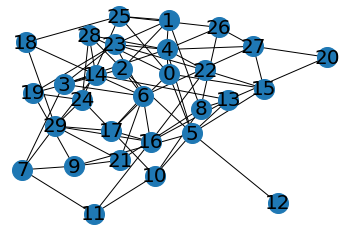

Runtime is 10.384897232055664 for 30 nodes.
QpuProgrammingTime is 11004 for 30 nodes.
QpuSamplingTime is 3241 for 30 nodes.
QpuAccessTime is 14245 for 30 nodes.
QpuAnnealTimePerSample is 100 for 30 nodes.
Valid partition found with 39 cut edges.


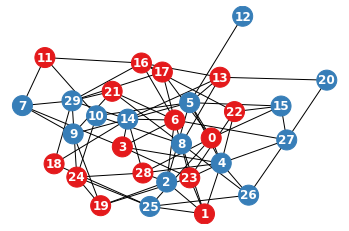

Graph on 40 nodes created with 153 out of 780.0 possible edges.


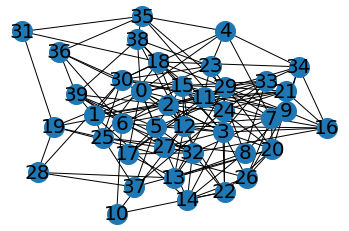

Runtime is 13.02079701423645 for 40 nodes.
QpuProgrammingTime is 10987 for 40 nodes.
QpuSamplingTime is 3237 for 40 nodes.
QpuAccessTime is 14224 for 40 nodes.
QpuAnnealTimePerSample is 100 for 40 nodes.
Valid partition found with 75 cut edges.


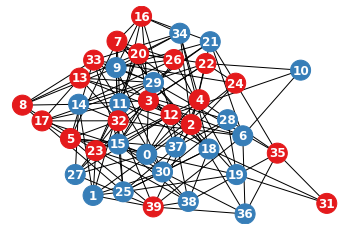

Graph on 50 nodes created with 249 out of 1225.0 possible edges.


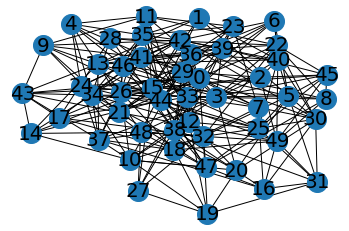

Runtime is 14.460739612579346 for 50 nodes.
QpuProgrammingTime is 11083 for 50 nodes.
QpuSamplingTime is 3244 for 50 nodes.
QpuAccessTime is 14327 for 50 nodes.
QpuAnnealTimePerSample is 100 for 50 nodes.
Valid partition found with 119 cut edges.


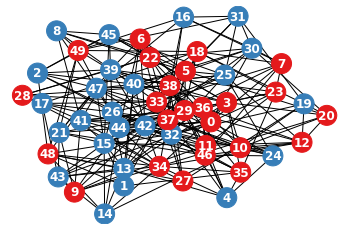

Graph on 60 nodes created with 331 out of 1770.0 possible edges.


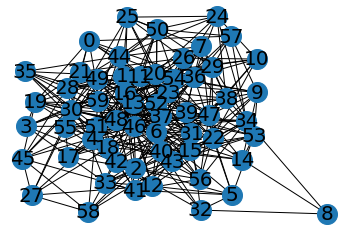

Runtime is 21.29997229576111 for 60 nodes.
QpuProgrammingTime is 11046 for 60 nodes.
QpuSamplingTime is 3244 for 60 nodes.
QpuAccessTime is 14291 for 60 nodes.
QpuAnnealTimePerSample is 100 for 60 nodes.
Valid partition found with 174 cut edges.


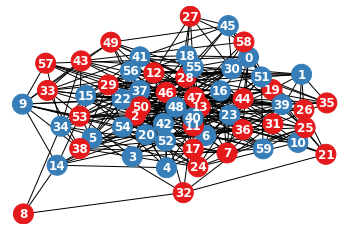

In [33]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 100 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes3 = [] # stores individual runtimes
QpuSamplingTimes3 = [] 
QpuAccessTimes3 = [] 
QpuProgrammingTimes3 = [] 
QpuAnnealTimePerSamples3 = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes3.append(runtime)
    QpuSamplingTimes3.append(QpuSamplingTime)
    QpuAccessTimes3.append(QpuAccessTime)
    QpuProgrammingTimes3.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples3.append(QpuAnnealTimePerSample)

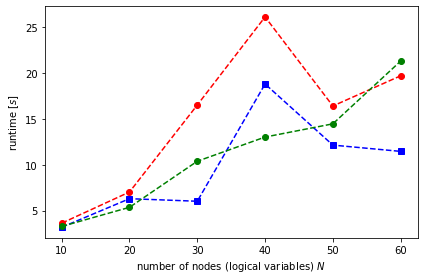

In [34]:
# plot runtime results
plt.plot(nodes, runtimes, 'b--s')
plt.plot(nodes, runtimes2, 'r--o')
plt.plot(nodes, runtimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('runtime $[s]$')
plt.tight_layout();
plt.savefig('dwave_wallclock_partitioning_shots_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

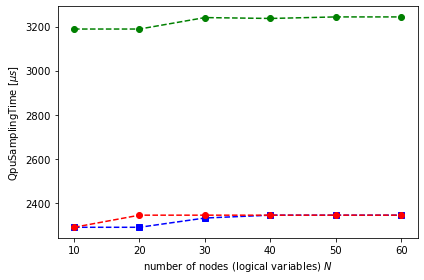

In [35]:
# plot runtime results
plt.plot(nodes, QpuSamplingTimes, 'b--s')
plt.plot(nodes, QpuSamplingTimes2, 'r--o')
plt.plot(nodes, QpuSamplingTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuSamplingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuSamplingTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

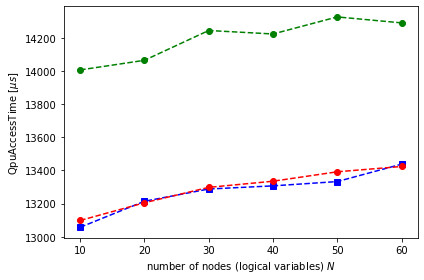

In [36]:
# plot runtime results
plt.plot(nodes, QpuAccessTimes, 'b--s')
plt.plot(nodes, QpuAccessTimes2, 'r--o')
plt.plot(nodes, QpuAccessTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAccessTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAccessTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

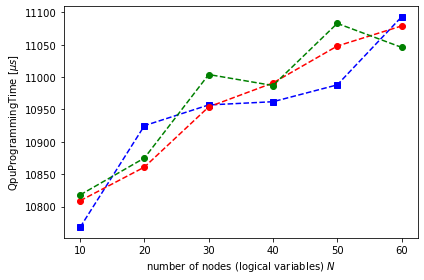

In [37]:
# plot runtime results
plt.plot(nodes, QpuProgrammingTimes, 'b--s')
plt.plot(nodes, QpuProgrammingTimes2, 'r--o')
plt.plot(nodes, QpuProgrammingTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuProgrammingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuProgrammingTime_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

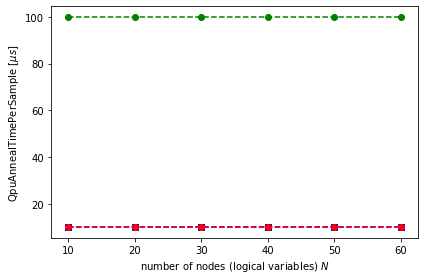

In [38]:
# plot runtime results
plt.plot(nodes, QpuAnnealTimePerSamples, 'b--s')
plt.plot(nodes, QpuAnnealTimePerSamples2, 'r--o')
plt.plot(nodes, QpuAnnealTimePerSamples3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAnnealTimePerSample $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAnnealTimePerSample_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

As expected, by increasing the ```annealing_time``` (per sample), the total QPU sampling times increase, thereby increasing the total QPU access time, while the QPU programming time has been left unaffected by this change. 

---
## REFERENCES

[1] F. Glover, G. Kochenberger, and Y. Du, *A Tutorial on Formulating and Using QUBO Models*, available online [here](http://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf). 

[2] P. Wittek, *Quantum Machine Learning*, [EdX online course](https://www.edx.org/course/quantum-machine-learning). 

[3] N. Dattani, S. Szalay and N. Chancellor, *Pegasus: The second connectivity graph for large-scale quantum annealing hardware*, available online [here](https://arxiv.org/abs/1901.07636).

In [39]:
# check the Braket SDK version
!pip show amazon-braket-sdk | grep Version

Version: 1.7.1
